Am folosit data setul de pe https://www.kaggle.com/datasets/hopesb/student-depression-dataset care cuprinde date despre si daca sunt depresivi sau nu

In [2]:
import sklearn
import numpy as np

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

from google.cloud.aiplatform.schema import dataset
from patsy.user_util import balanced
from plotly.data import experiment


def load_depresion_data():
    return pd.read_csv(Path("data/student_depression_dataset.csv"))


depresion = load_depresion_data()

Prima data ne uitam ce coloane avem

In [3]:
depresion.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


Am observat ca contine atat valori numerice cat si stringuri cea ce nu e ok din cauza ca modelul putea produce anumite preziceri eronate din cauza ca acestea nu au valori matematice. De exemplu daca majoritatea studentilor depresivi ar avea orasul de provenienta din 6 litere ar insemna ca daca esti dintr-un astfel de oras esti depresiv ceea ce nu e ft corect sau modelele de tip knn sau svm ar calcula distante dintre valori de exemplu la degrees. Deci eu sa incerc sa scap de string-uri prin doua metode, stergerea coloanei si a acelei informatii (in cazul orasului) sau adaptarea acelui string in mai multe categorii prin intermediul unor HotEncoder. Folosesc Hot Encoder din cauza ca sunt valori de 0 sau 1 spre deosebire de LabelEncoder care are de la 0 la cate categorii ai si astfel previn ca modelul sa inteleaga eronat datele. De exemplul degree-ul acesta este mai important din cauza ca are valoarea 3 sau 4 si nu 1 sau 2. Label Encoder se foloseste mai mult pentru a defini relatie de bine-reu. 

Hai sa vedem cate feluri de elemente din fiecare tip care au valoare de tip string avem

In [4]:
unique_degree = depresion['Degree'].unique()
unique_degree.sort()
unique_degree

array(["'Class 12'", 'B.Arch', 'B.Com', 'B.Ed', 'B.Pharm', 'B.Tech', 'BA',
       'BBA', 'BCA', 'BE', 'BHM', 'BSc', 'LLB', 'LLM', 'M.Com', 'M.Ed',
       'M.Pharm', 'M.Tech', 'MA', 'MBA', 'MBBS', 'MCA', 'MD', 'ME', 'MHM',
       'MSc', 'Others', 'PhD'], dtype=object)

In [5]:
unique_city = depresion['City'].unique()
unique_city.sort()
unique_city

array(["'Less Delhi'", "'Less than 5 Kalyan'", '3.0', 'Agra', 'Ahmedabad',
       'Bangalore', 'Bhavna', 'Bhopal', 'Chennai', 'City', 'Delhi',
       'Faridabad', 'Gaurav', 'Ghaziabad', 'Harsh', 'Harsha', 'Hyderabad',
       'Indore', 'Jaipur', 'Kalyan', 'Kanpur', 'Khaziabad', 'Kibara',
       'Kolkata', 'Lucknow', 'Ludhiana', 'M.Com', 'M.Tech', 'ME',
       'Meerut', 'Mihir', 'Mira', 'Mumbai', 'Nagpur', 'Nalini', 'Nalyan',
       'Nandini', 'Nashik', 'Patna', 'Pune', 'Rajkot', 'Rashi', 'Reyansh',
       'Saanvi', 'Srinagar', 'Surat', 'Thane', 'Vaanya', 'Vadodara',
       'Varanasi', 'Vasai-Virar', 'Visakhapatnam'], dtype=object)

In [6]:
unique_profession = depresion['Profession'].unique()
unique_profession.sort()
unique_profession

array(["'Civil Engineer'", "'Content Writer'", "'Digital Marketer'",
       "'Educational Consultant'", "'UX/UI Designer'", 'Architect',
       'Chef', 'Doctor', 'Entrepreneur', 'Lawyer', 'Manager',
       'Pharmacist', 'Student', 'Teacher'], dtype=object)

In [7]:
sleep_duration = depresion['Sleep Duration'].unique()
sleep_duration.sort()
sleep_duration

array(["'5-6 hours'", "'7-8 hours'", "'Less than 5 hours'",
       "'More than 8 hours'", 'Others'], dtype=object)

Aici m-a luat curiozitatea pe dinainte ca am vrut sa vad cum influentiaza fiecare caracteristica faptul daca e depresiv sau nu. Corelația măsoară cât de mult variază două variabile împreună. Dacă variabilele sunt pozitiv corelate, atunci pe măsură ce una crește, și cealaltă crește. Dacă sunt negativ corelate, atunci pe măsură ce una crește, cealaltă scade. Dacă nu există corelație, modificările unei variabile nu influențează cealaltă. Deci pe scurt ne intereseaza valorile apropiate de 1 si -1 din cauza ca ele sunt cele care sunt in cea mai stransa legatura cu rezultatul. Am zis ca m-am grabit din cauza ca matricea de corelatie nu functioneaza cu string-uri si doar cu valori numerice si nu am inca full picture.

In [8]:
corr = depresion.corr(numeric_only=True)
corr["Depression"].sort_values(ascending=False)

Depression            1.000000
Academic Pressure     0.474835
Work/Study Hours      0.208563
CGPA                  0.022210
id                    0.000923
Work Pressure        -0.003351
Job Satisfaction     -0.003482
Study Satisfaction   -0.167971
Age                  -0.226422
Name: Depression, dtype: float64

Deci momentan stim ca daca esti depresiv esti cel mai probabil depresiv chiar 1 la 1 (destul de evident) dar vedem si ca cu cat lucrezi mai mult sau ai o presiune academica mai mare cu atata ai sanse mai mari sa fii depresiv. Daca ne uitam si la valorile negative vedem si o inclinatie spre depresie la o varsta mai mica si cand nu ai satisfactie asa de mare cand inveti

Inainte de a face ceva schimbari majore la date hai sa le mai analizam o data si sa vedem ochiometric ce valori avem, ne mai facem ceva idei

In [9]:
depresion

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,'Less than 5 hours',Healthy,'Class 12',Yes,10.0,5.0,No,1


Hai sa vedem daca avem toate datele pentru fiecare (nu sunt lipsuri), o sa vedem mai incolo ca exista si sunt notate cu ?

In [10]:
depresion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

Ne facem o idee de cum sunt valorile la date

In [11]:
depresion.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,1.000000


partea buna e ca e bun raportul intre depresivi si nedepresivi dar vom mai realiza niste schimbari si se va schimba mult aceste numere

In [12]:
profession_counts = depresion['Profession'].value_counts()
print(profession_counts)

Profession
Student                     27870
Architect                       8
Teacher                         6
'Digital Marketer'              3
'Content Writer'                2
Chef                            2
Doctor                          2
Pharmacist                      2
'Civil Engineer'                1
'UX/UI Designer'                1
'Educational Consultant'        1
Manager                         1
Lawyer                          1
Entrepreneur                    1
Name: count, dtype: int64


hmmmm, majoritatea oamenilor care sunt in acest dataset sunt studenti

In [13]:
profession_counts = depresion['Degree'].value_counts()
print(profession_counts)

Degree
'Class 12'    6080
B.Ed          1867
B.Com         1506
B.Arch        1478
BCA           1433
MSc           1190
B.Tech        1152
MCA           1044
M.Tech        1022
BHM            925
BSc            888
M.Ed           821
B.Pharm        810
M.Com          734
MBBS           696
BBA            696
LLB            671
BE             613
BA             600
M.Pharm        582
MD             572
MBA            562
MA             544
PhD            522
LLM            482
MHM            191
ME             185
Others          35
Name: count, dtype: int64


aici e mai diversificat dar cei din class 12 reprezinta o clasa dominanta si fiind asa de mare discrepanta ar putea duce la o defavorizare a performantei celorlalte clase. Aici sunt mai multe metode cum putem proceda iar eu am ales sa micsorez numarul celor din clasa 12 la 1800 si cele care au sub 500 sa le pun impreuna sub denumirea de others. Nu e chiar cea mai buna tehnica dar nici nu am vrut sa supra-analizez datele si sa scot mai mult din cauza ca risc sa pierd date importante. Puteam si sa scot toata coloana dar cred ca degree-ul e important. Puteam sa reduc si toate la 500 dar nu am vrut sa trunchiez asa de mult dataset-ul sau puteam stratifica dar si metoda aia mi s-a parut destul de lucratoare si ajuta pentru acuratete mai crescuta si prin faptul ca nu avem un nivel tinta de acuratete sau precizie am preferat sa nu ma complic si sa folosesc cross validation pentru training ca optimizare

In [16]:
# 1. Copy your original dataset
dataset = depresion.copy()

# 2. Group rare degrees into 'Other'
degree_counts = dataset['Degree'].value_counts()
rare_degrees = degree_counts[degree_counts < 500].index

dataset['Degree'] = dataset['Degree'].replace(rare_degrees, 'Other')

# 3. Split 'Class 12' and other degrees
class12_df = dataset[dataset['Degree'] == "'Class 12'"]
other_degrees_df = dataset[dataset['Degree'] != "'Class 12'"]

# 4. Downsample 'Class 12' to exactly 1800 samples
class12_downsampled = class12_df.sample(n=1800, random_state=42)

# 5. Combine downsampled 'Class 12' with other degrees
dataset_balanced = pd.concat([class12_downsampled, other_degrees_df])

# 6. Shuffle the dataset
dataset_balanced = dataset_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 7. Optional: Check new distribution
print(dataset_balanced['Degree'].value_counts())


Degree
B.Ed          1867
'Class 12'    1800
B.Com         1506
B.Arch        1478
BCA           1433
MSc           1190
B.Tech        1152
MCA           1044
M.Tech        1022
BHM            925
Other          893
BSc            888
M.Ed           821
B.Pharm        810
M.Com          734
MBBS           696
BBA            696
LLB            671
BE             613
BA             600
M.Pharm        582
MD             572
MBA            562
MA             544
PhD            522
Name: count, dtype: int64


Din cauza ca majoritatea sunt studenti, 40 nu erau si restul cateva mii sunt atunci acesti outliers si daca i-as grupa tot ar strica modelul din cauza ca sunt prea putin si nu poate generaliza asa ca prefer sa-i scot si dupa sa scot coloana din cauza ca acum toti sunt studenti

In [17]:
dataset_balanced = dataset_balanced[dataset_balanced['Profession'] == 'Student'].copy()

print(dataset_balanced['Profession'].value_counts())


Profession
Student    23590
Name: count, dtype: int64


In [18]:
dataset_balanced = dataset_balanced.drop(columns=['Profession'])


Sa vedem daca s-au facut schimbarile si ce mai avem de facut

In [19]:
dataset_balanced

,id,Gender,Age,City,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,131979,Male,24.0,Bangalore,4.0,0.0,7.88,2.0,0.0,'5-6 hours',Unhealthy,B.Arch,Yes,11.0,5.0,No,1
1,23776,Male,26.0,Nashik,2.0,0.0,6.78,2.0,0.0,'Less than 5 hours',Unhealthy,B.Com,No,0.0,2.0,Yes,0
2,103468,Female,27.0,Ahmedabad,3.0,0.0,9.72,4.0,0.0,'Less than 5 hours',Unhealthy,B.Com,No,3.0,3.0,No,1
3,10529,Male,26.0,Jaipur,5.0,0.0,7.42,3.0,0.0,'5-6 hours',Healthy,BE,Yes,3.0,2.0,No,0
4,75644,Female,33.0,Kanpur,5.0,0.0,7.92,2.0,0.0,'Less than 5 hours',Moderate,B.Ed,No,11.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23616,65695,Female,26.0,Thane,5.0,0.0,5.85,3.0,0.0,'More than 8 hours',Healthy,B.Pharm,Yes,2.0,5.0,No,1
23617,127282,Male,32.0,Pune,3.0,0.0,7.88,4.0,0.0,'Less than 5 hours',Unhealthy,MD,No,12.0,5.0,Yes,1
23618,23085,Female,31.0,Surat,3.0,0.0,5.56,4.0,0.0,'More than 8 hours',Healthy,PhD,No,7.0,3.0,Yes,0
23619,2312,Female,30.0,Mumbai,2.0,0.0,7.21,3.0,0.0,'More than 8 hours',Unhealthy,'Class 12',Yes,11.0,1.0,Yes,1


Am zis de la inceput ca orasul nu consider ca avand asa de mare intrebuinta si fiind asa de multe mai mult de aglomereaza setul de date de cat ne ajuta asa ca il scoatem

In [20]:
dataset_balanced = dataset_balanced.drop(columns=['City'])

In [21]:
dataset_balanced

,id,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,131979,Male,24.0,4.0,0.0,7.88,2.0,0.0,'5-6 hours',Unhealthy,B.Arch,Yes,11.0,5.0,No,1
1,23776,Male,26.0,2.0,0.0,6.78,2.0,0.0,'Less than 5 hours',Unhealthy,B.Com,No,0.0,2.0,Yes,0
2,103468,Female,27.0,3.0,0.0,9.72,4.0,0.0,'Less than 5 hours',Unhealthy,B.Com,No,3.0,3.0,No,1
3,10529,Male,26.0,5.0,0.0,7.42,3.0,0.0,'5-6 hours',Healthy,BE,Yes,3.0,2.0,No,0
4,75644,Female,33.0,5.0,0.0,7.92,2.0,0.0,'Less than 5 hours',Moderate,B.Ed,No,11.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23616,65695,Female,26.0,5.0,0.0,5.85,3.0,0.0,'More than 8 hours',Healthy,B.Pharm,Yes,2.0,5.0,No,1
23617,127282,Male,32.0,3.0,0.0,7.88,4.0,0.0,'Less than 5 hours',Unhealthy,MD,No,12.0,5.0,Yes,1
23618,23085,Female,31.0,3.0,0.0,5.56,4.0,0.0,'More than 8 hours',Healthy,PhD,No,7.0,3.0,Yes,0
23619,2312,Female,30.0,2.0,0.0,7.21,3.0,0.0,'More than 8 hours',Unhealthy,'Class 12',Yes,11.0,1.0,Yes,1


Am uitat sa ma uit la durata de somn

In [22]:
sleep_duration = dataset_balanced['Sleep Duration'].value_counts()
print(sleep_duration)

Sleep Duration
'Less than 5 hours'    7046
'7-8 hours'            6220
'5-6 hours'            5263
'More than 8 hours'    5043
Others                   18
Name: count, dtype: int64


Sunt destul de echilibrate sectiunile inafara de cea de others care nu stiu unde sa-i incadrez asa ca prefer sa-i scot

In [23]:
dataset_balanced = dataset_balanced[dataset_balanced['Sleep Duration'] != 'Others']


Hai sa vedem si la dieta

In [24]:
diet = dataset_balanced['Dietary Habits'].value_counts()
print(diet)  

Dietary Habits
Unhealthy    8605
Moderate     8429
Healthy      6527
Others         11
Name: count, dtype: int64


E aceasi chestie si scoatem others

In [25]:
dataset_balanced = dataset_balanced[dataset_balanced['Dietary Habits'] != 'Others']
print(dataset_balanced['Dietary Habits'].value_counts())

Dietary Habits
Unhealthy    8605
Moderate     8429
Healthy      6527
Name: count, dtype: int64


Acum transformam orice avem de tip string in 0 sau 1. La 'Gender', 'Have you ever had suicidal thoughts ?' si 'Family History of Mental Illness' fiind doar categorii la fiecare facem cu label encoder si la celelalte 'Degree', 'Dietary Habits' si 'Sleep Duration' folosim hot encoder care face mai multe coloane (in loc de o coloana cu string vom avea mai multe coloane de tip adevarat sau fals (1 si 0) cu variantele care erau reprezentate de acele string-uri

In [26]:
balanced_dataset_copy = dataset_balanced.copy()

In [27]:
from sklearn.preprocessing import LabelEncoder

label_enc_cols = ['Gender', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

le = LabelEncoder()

for col in label_enc_cols:
    dataset_balanced.loc[:, col] = le.fit_transform(dataset_balanced[col])

onehot_cols = ['Degree', 'Dietary Habits', 'Sleep Duration']

dataset_balanced = pd.get_dummies(dataset_balanced, columns=onehot_cols, drop_first=True)

print(dataset_balanced.head())


       id Gender   Age  Academic Pressure  Work Pressure  CGPA  \
0  131979      1  24.0                4.0            0.0  7.88   
1   23776      1  26.0                2.0            0.0  6.78   
2  103468      0  27.0                3.0            0.0  9.72   
3   10529      1  26.0                5.0            0.0  7.42   
4   75644      0  33.0                5.0            0.0  7.92   

   Study Satisfaction  Job Satisfaction Have you ever had suicidal thoughts ?  \
0                 2.0               0.0                                     1   
1                 2.0               0.0                                     0   
2                 4.0               0.0                                     0   
3                 3.0               0.0                                     1   
4                 2.0               0.0                                     0   

   Work/Study Hours  ... Degree_MCA Degree_MD  Degree_MSc  Degree_Other  \
0              11.0  ...      False     F

Aici am dat drop la prima coloana din hot encoderdin cauza ca e dedusa din celelalte si ca sa evitam multicoliniaritatea

In [28]:
dataset_balanced   

,id,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,...,Degree_MCA,Degree_MD,Degree_MSc,Degree_Other,Degree_PhD,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Duration_'7-8 hours',Sleep Duration_'Less than 5 hours',Sleep Duration_'More than 8 hours'
0,131979,1,24.0,4.0,0.0,7.88,2.0,0.0,1,11.0,...,False,False,False,False,False,False,True,False,False,False
1,23776,1,26.0,2.0,0.0,6.78,2.0,0.0,0,0.0,...,False,False,False,False,False,False,True,False,True,False
2,103468,0,27.0,3.0,0.0,9.72,4.0,0.0,0,3.0,...,False,False,False,False,False,False,True,False,True,False
3,10529,1,26.0,5.0,0.0,7.42,3.0,0.0,1,3.0,...,False,False,False,False,False,False,False,False,False,False
4,75644,0,33.0,5.0,0.0,7.92,2.0,0.0,0,11.0,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23616,65695,0,26.0,5.0,0.0,5.85,3.0,0.0,1,2.0,...,False,False,False,False,False,False,False,False,False,True
23617,127282,1,32.0,3.0,0.0,7.88,4.0,0.0,0,12.0,...,False,True,False,False,False,False,True,False,True,False
23618,23085,0,31.0,3.0,0.0,5.56,4.0,0.0,0,7.0,...,False,False,False,False,True,False,False,False,False,True
23619,2312,0,30.0,2.0,0.0,7.21,3.0,0.0,1,11.0,...,False,False,False,False,False,False,True,False,False,True


La HotEncoder ne-a facut cu True sau False cea ce imi displace asa ca tot ce e cu true facem 1 si ce e cu false facem 0

In [29]:
# Convert all True/False to 1/0
dataset_balanced = dataset_balanced.replace({True: 1, False: 0})


C:\Users\Asus\AppData\Local\Temp\ipykernel_37380\2105304156.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_balanced = dataset_balanced.replace({True: 1, False: 0})


In [30]:
dataset_balanced

,id,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,...,Degree_MCA,Degree_MD,Degree_MSc,Degree_Other,Degree_PhD,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Duration_'7-8 hours',Sleep Duration_'Less than 5 hours',Sleep Duration_'More than 8 hours'
0,131979,1,24.0,4.0,0.0,7.88,2.0,0.0,1,11.0,...,0,0,0,0,0,0,1,0,0,0
1,23776,1,26.0,2.0,0.0,6.78,2.0,0.0,0,0.0,...,0,0,0,0,0,0,1,0,1,0
2,103468,0,27.0,3.0,0.0,9.72,4.0,0.0,0,3.0,...,0,0,0,0,0,0,1,0,1,0
3,10529,1,26.0,5.0,0.0,7.42,3.0,0.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
4,75644,0,33.0,5.0,0.0,7.92,2.0,0.0,0,11.0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23616,65695,0,26.0,5.0,0.0,5.85,3.0,0.0,1,2.0,...,0,0,0,0,0,0,0,0,0,1
23617,127282,1,32.0,3.0,0.0,7.88,4.0,0.0,0,12.0,...,0,1,0,0,0,0,1,0,1,0
23618,23085,0,31.0,3.0,0.0,5.56,4.0,0.0,0,7.0,...,0,0,0,0,1,0,0,0,0,1
23619,2312,0,30.0,2.0,0.0,7.21,3.0,0.0,1,11.0,...,0,0,0,0,0,0,1,0,0,1


id-ul e de asemenea o coloana cu valori care pot fi foarte mari care nu influentiaza deloc starea mentala a persoanei si care ne poate produce rezultate eronate asa ca o stergem

In [31]:
dataset_balanced = dataset_balanced.drop(columns=['id'])

In [32]:
dataset_balanced

,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,...,Degree_MCA,Degree_MD,Degree_MSc,Degree_Other,Degree_PhD,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Duration_'7-8 hours',Sleep Duration_'Less than 5 hours',Sleep Duration_'More than 8 hours'
0,1,24.0,4.0,0.0,7.88,2.0,0.0,1,11.0,5.0,...,0,0,0,0,0,0,1,0,0,0
1,1,26.0,2.0,0.0,6.78,2.0,0.0,0,0.0,2.0,...,0,0,0,0,0,0,1,0,1,0
2,0,27.0,3.0,0.0,9.72,4.0,0.0,0,3.0,3.0,...,0,0,0,0,0,0,1,0,1,0
3,1,26.0,5.0,0.0,7.42,3.0,0.0,1,3.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,0,33.0,5.0,0.0,7.92,2.0,0.0,0,11.0,1.0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23616,0,26.0,5.0,0.0,5.85,3.0,0.0,1,2.0,5.0,...,0,0,0,0,0,0,0,0,0,1
23617,1,32.0,3.0,0.0,7.88,4.0,0.0,0,12.0,5.0,...,0,1,0,0,0,0,1,0,1,0
23618,0,31.0,3.0,0.0,5.56,4.0,0.0,0,7.0,3.0,...,0,0,0,0,1,0,0,0,0,1
23619,0,30.0,2.0,0.0,7.21,3.0,0.0,1,11.0,1.0,...,0,0,0,0,0,0,1,0,0,1


Hai acum sa vedem ce corelatii avem

In [33]:
corr = dataset_balanced.corr(numeric_only=True)
corr["Depression"].sort_values(ascending=False)

Depression                               1.000000
Have you ever had suicidal thoughts ?    0.550127
Academic Pressure                        0.474559
Work/Study Hours                         0.208161
Dietary Habits_Unhealthy                 0.190256
Sleep Duration_'Less than 5 hours'       0.080829
Family History of Mental Illness         0.053154
CGPA                                     0.029067
Degree_B.Arch                            0.014239
Sleep Duration_'7-8 hours'               0.012111
Degree_BSc                               0.010503
Degree_BBA                               0.007617
Degree_MBBS                              0.006101
Degree_BCA                               0.004680
Degree_MSc                               0.003304
Degree_B.Tech                            0.002606
Degree_B.Com                             0.001751
Gender                                   0.001363
Job Satisfaction                        -0.003179
Degree_PhD                              -0.004043


In [34]:
exper = dataset_balanced.copy()

In [35]:

exp = exper[['Depression', 'Have you ever had suicidal thoughts ?', 'Academic Pressure', 
             'Work/Study Hours', 'Work/Study Hours', 'Dietary Habits_Moderate', 
             'Dietary Habits_Unhealthy', 'Study Satisfaction', 
             'Age', 'CGPA']]


Am incercat si asa, cu mai putine caracteristici, dar am avut rezultate putin mai rele pe primele 3 modele folosite

Ar trebui sa caut ceva combinatii mai bune dar rezultatul nu e dezastros cu exceptia la knn. Ne avand un obiectiv clar un rezultat intre 82-87 nu e rau, e ok, oricum un target ar fi peste 90 dar am si un raport intre precizie si acuratete destul de bun

In [36]:
dataset_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23561 entries, 0 to 23620
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 23561 non-null  int64  
 1   Age                                    23561 non-null  float64
 2   Academic Pressure                      23561 non-null  float64
 3   Work Pressure                          23561 non-null  float64
 4   CGPA                                   23561 non-null  float64
 5   Study Satisfaction                     23561 non-null  float64
 6   Job Satisfaction                       23561 non-null  float64
 7   Have you ever had suicidal thoughts ?  23561 non-null  int64  
 8   Work/Study Hours                       23561 non-null  float64
 9   Financial Stress                       23561 non-null  object 
 10  Family History of Mental Illness       23561 non-null  int64  
 11  Depress

In [37]:
scaled_dataset = dataset_balanced.copy()

Am observat ca avem valori si de ? si vrem sa vedem cate

In [38]:
rows_with_question_mark = (dataset_balanced == '?').any(axis=1).sum()

print(f"Number of rows with at least one '?': {rows_with_question_mark}")


Number of rows with at least one '?': 3


pfff sunt doar 3 asa ca le scoatem

In [39]:
dataset_balanced = dataset_balanced[~(dataset_balanced == '?').any(axis=1)]

dataset_balanced = dataset_balanced.reset_index(drop=True)

print(f"New dataset size: {dataset_balanced.shape}")


New dataset size: (23558, 41)


buunnn, vedem ca ave, valori diferite unele mai mari pana la 59 la varsta si cu cea mai mica la 18 si cgpa pana la 10 si ca imbunatatim modelul le scalam pe toate care nu reprezinta o categorie. Daca nu am face asta s-ar putea ca modelul sa fie influentat de acele valori mai mari dintr-o anumita coloana. Nu e asa de mare diferenta cum a fost la problema de regresie, de exemplu varsta casei 10 ani si valoarea 123000 cea ce ii enorm, dar am facut-o oricum

In [40]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']

scaler = StandardScaler()

dataset_balanced[numeric_cols] = scaler.fit_transform(dataset_balanced[numeric_cols])

print(dataset_balanced[numeric_cols].head())


        Age  Academic Pressure  Work Pressure      CGPA  Study Satisfaction  \
0 -0.646339           0.647399      -0.006515  0.142542           -0.676111   
1 -0.193864          -0.789111      -0.006515 -0.602785           -0.676111   
2  0.032373          -0.070856      -0.006515  1.389270            0.798141   
3 -0.193864           1.365654      -0.006515 -0.169141            0.061015   
4  1.389798           1.365654      -0.006515  0.169644           -0.676111   

   Job Satisfaction  Work/Study Hours  Financial Stress  
0         -0.011776          1.037863          1.309422  
1         -0.011776         -1.917402         -0.775470  
2         -0.011776         -1.111420         -0.080506  
3         -0.011776         -1.111420         -0.775470  
4         -0.011776          1.037863         -1.470434  


In [41]:
dataset_balanced

,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,...,Degree_MCA,Degree_MD,Degree_MSc,Degree_Other,Degree_PhD,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Duration_'7-8 hours',Sleep Duration_'Less than 5 hours',Sleep Duration_'More than 8 hours'
0,1,-0.646339,0.647399,-0.006515,0.142542,-0.676111,-0.011776,1,1.037863,1.309422,...,0,0,0,0,0,0,1,0,0,0
1,1,-0.193864,-0.789111,-0.006515,-0.602785,-0.676111,-0.011776,0,-1.917402,-0.775470,...,0,0,0,0,0,0,1,0,1,0
2,0,0.032373,-0.070856,-0.006515,1.389270,0.798141,-0.011776,0,-1.111420,-0.080506,...,0,0,0,0,0,0,1,0,1,0
3,1,-0.193864,1.365654,-0.006515,-0.169141,0.061015,-0.011776,1,-1.111420,-0.775470,...,0,0,0,0,0,0,0,0,0,0
4,0,1.389798,1.365654,-0.006515,0.169644,-0.676111,-0.011776,0,1.037863,-1.470434,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23553,0,-0.193864,1.365654,-0.006515,-1.232926,0.061015,-0.011776,1,-1.380081,1.309422,...,0,0,0,0,0,0,0,0,0,1
23554,1,1.163560,-0.070856,-0.006515,0.142542,0.798141,-0.011776,0,1.306524,1.309422,...,0,1,0,0,0,0,1,0,1,0
23555,0,0.937323,-0.070856,-0.006515,-1.429421,0.798141,-0.011776,0,-0.036779,-0.080506,...,0,0,0,0,1,0,0,0,0,1
23556,0,0.711085,-0.789111,-0.006515,-0.311430,0.061015,-0.011776,1,1.037863,-1.470434,...,0,0,0,0,0,0,1,0,0,1


Aici am mai verificat daca avem un raport ok intre depresivi si nedepresivi. Nu e chiar 50% dar nu e rau

In [42]:
y = dataset_balanced['Depression']
y.value_counts()

Depression
1    13252
0    10306
Name: count, dtype: int64

Acum impartim testul in doua grupuri train si test unde 0.2 e test si 0.8 train. Am folosit random_state din cauza ca le-a amestecat random dar mereu le va amesteca la fel daca apelam functia in programul nostru cu aceasi valoare, in caul nostru 42. 42 e o valoare random am ales-o din cauza ca e destul de folosita in exemple. 

In [47]:
from sklearn.model_selection import train_test_split

X = dataset_balanced.drop(columns=['Depression'])  # replace 

y = dataset_balanced['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Eu m-am decis să urmez o metodă bine stabilită pentru evaluarea unui model de învățare automată, care include utilizarea cross-validation pe setul de antrenament, urmată de antrenarea finală a modelului pe întregul set de antrenament și evaluarea acestuia pe setul de test. Primul pas, cross-validation, este esențial pentru a preveni overfitting-ul. Overfitting-ul apare atunci când un model se adaptează prea bine la datele de antrenament, învățând nu doar relațiile generale, ci și zgomotul și detaliile irelevante, ceea ce duce la o performanță excelentă pe datele de antrenament, dar slabă pe date noi, neîntâlnite.

Prin utilizarea cross-validation, modelez performanța pe mai multe subseturi de date, ceea ce mă ajută să identific potențialele probleme de overfitting, deoarece modelul este evaluat pe date pe care nu le-a văzut în timpul antrenării. După ce am efectuat cross-validation, antrenez modelul pe întregul set de antrenament pentru a-l optimiza și a-i oferi toate datele posibile pentru învățare. În final, pentru a evalua adevărata capacitate de generalizare a modelului, îl testez pe setul de test, care nu a fost utilizat nici pentru antrenament, nici pentru validare. Această abordare îmi oferă o evaluare mai precisă și corectă a performanței modelului și mă asigură că acesta poate generaliza eficient la date noi, fără a fi afectat de overfitting.

# Metricile folosite pentru evaluarea performanței modelului

- **Acuratețea (Accuracy)**: Măsoară proporția totală de predicții corecte efectuate de model.
- **Precizia (Precision)**: Indică proporția instanțelor pozitive corect clasificate în raport cu toate instanțele prezise ca pozitive.
- **Recall (Sensibilitate)**: Măsoară proporția instanțelor pozitive corect identificate în raport cu toate instanțele care sunt de fapt pozitive.
- **F1-Score**: Combină precizia și recall-ul într-o singură măsură, oferind un echilibru între cele două.
- **AUC (Area Under the Curve)**: Măsoară capacitatea modelului de a separa corect clasele pozitive de cele negative. 
- **ROC Curve**: Reprezintă grafic performanța modelului la diferite praguri de decizie.
- **Confusion Matrix**: Arată distribuția predicțiilor corecte și greșite ale modelului, detaliind instanțele clasificate ca pozitive și negative, corect sau greșit.



=== Cross-Validation on Training Set ===
Accuracy: 0.8438
Precision: 0.8493
Recall: 0.8776
F1-Score: 0.8632
AUC: 0.9197


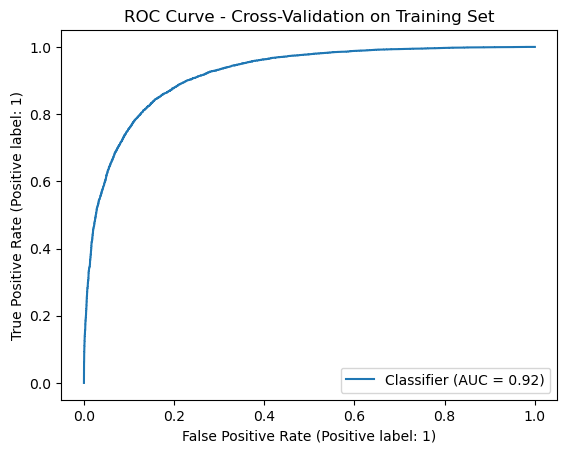

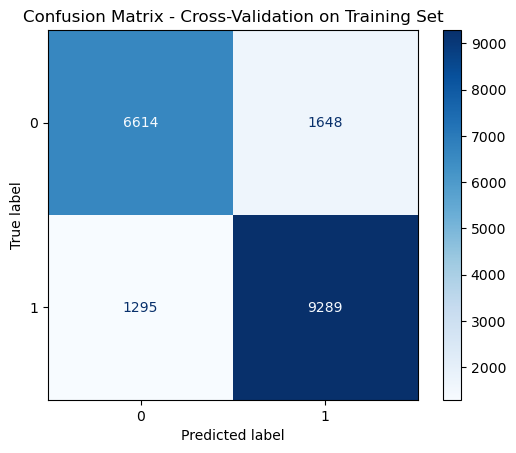


=== Final Evaluation on Test Set ===
Test Accuracy: 0.8457
Test Precision: 0.8556
Test Recall: 0.8752
Test F1-Score: 0.8653
Test AUC: 0.9224


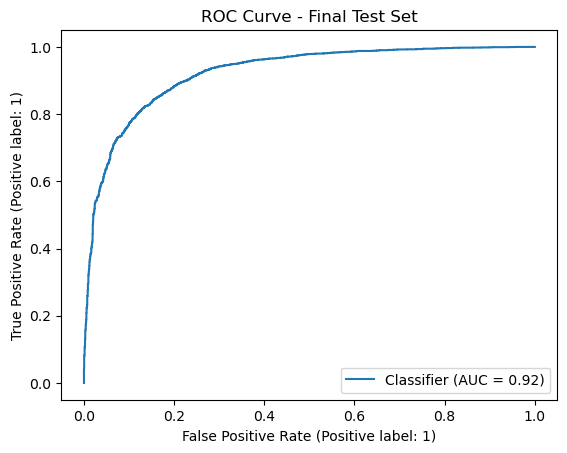

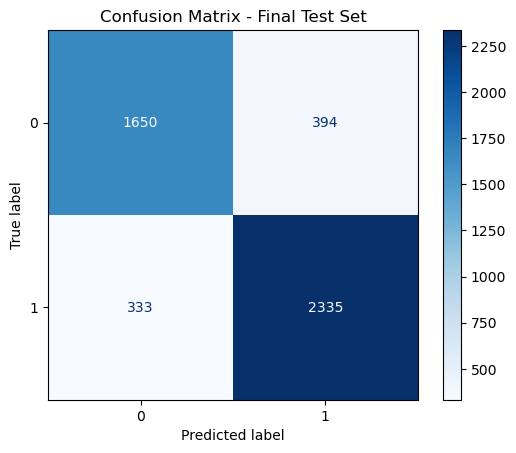

In [48]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




kfold = KFold(n_splits=5, shuffle=True, random_state=42)

logreg = LogisticRegression(max_iter=1000)

y_train_pred_cv = cross_val_predict(logreg, X_train, y_train, cv=kfold, method='predict')
y_train_proba_cv = cross_val_predict(logreg, X_train, y_train, cv=kfold, method='predict_proba')[:, 1]

print("\n=== Cross-Validation on Training Set ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_cv):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_cv):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_cv):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_cv):.4f}")

RocCurveDisplay.from_predictions(y_train, y_train_proba_cv)
plt.title('ROC Curve - Cross-Validation on Training Set')
plt.show()

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred_cv)).plot(cmap='Blues')
plt.title('Confusion Matrix - Cross-Validation on Training Set')
plt.show()

logreg_final = LogisticRegression(max_iter=1000)
logreg_final.fit(X_train, y_train)

y_test_pred = logreg_final.predict(X_test)
y_test_proba = logreg_final.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Final Test Set')
plt.show()

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Final Test Set')
plt.show()

### Analiza Performanței Modelului

#### Performanța pe Setul de Antrenament (Cross-Validation):

- **Acuratețe (Accuracy)**: 0.8438  
  Modelul a realizat predicții corecte în aproximativ 84.38% din cazuri pe datele de antrenament.

- **Precizie (Precision)**: 0.8493  
  Dintre instanțele prezise ca pozitive, aproximativ 85% au fost într-adevăr pozitive.

- **Recall (Sensibilitate)**: 0.8776  
  Modelul a identificat corect aproximativ 87.76% dintre instanțele pozitive.

- **F1-Score**: 0.8632  
  O valoare bună a F1-Score, indicând un echilibru între precizie și recall.

- **AUC (Area Under the Curve)**: 0.9197  
  AUC-ul aproape de 1 indică o performanță excelentă a modelului în separarea corectă a claselor pozitive și negative.

#### Performanța pe Setul de Test:

- **Test Accuracy**: 0.8457  
  O acuratețe de 84.57% pe setul de test, care este similară cu performanța pe setul de antrenament, sugerând o bună generalizare.

- **Test Precision**: 0.8556  
  Modelul a prezis corect aproximativ 85.56% dintre instanțele pozitive pe setul de test.

- **Test Recall**: 0.8752  
  Modelul a identificat 87.52% dintre instanțele pozitive din setul de test.

- **Test F1-Score**: 0.8653  
  Un F1-Score ridicat indică un echilibru între precizie și recall pe setul de test.

- **Test AUC**: 0.9224  
  AUC-ul pe setul de test este similar cu cel de pe setul de antrenament, ceea ce sugerează o performanță excelentă și o bună generalizare.

#### Analiza Matricei de Confuzie:

- **Setul de Antrenament**:
  - Instanțele negative corect clasificate: 6614 (True Negatives - TN)
  - Instanțele pozitive corect clasificate: 9289 (True Positives - TP)
  - False pozitive: 1648 (False Positives - FP)
  - False negative: 1295 (False Negatives - FN)

- **Setul de Test**:
  - Instanțele negative corect clasificate: 1650 (True Negatives - TN)
  - Instanțele pozitive corect clasificate: 2335 (True Positives - TP)
  - False pozitive: 394 (False Positives - FP)
  - False negative: 333 (False Negatives - FN)

Aceste valori reflectă o performanță bună a modelului în identificarea corectă a instanțelor pozitive și negative, atât pe setul de antrenament, cât și pe cel de test.

#### Concluzie:
Modelul a demonstrat o performanță buna, cu valori mari pentru toate măsurile de performanță (precizie, recall, F1-Score, AUC), indicând o bună generalizare. Acesta este capabil să facă predicții fiabile pe date noi, fără a fi afectat de overfitting.


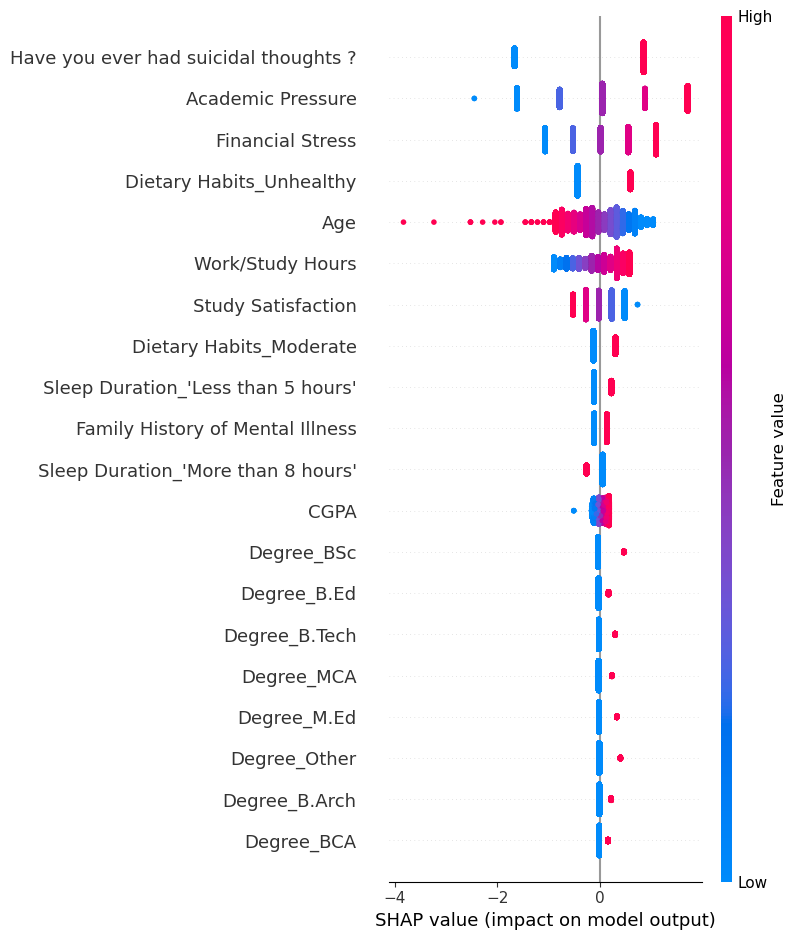

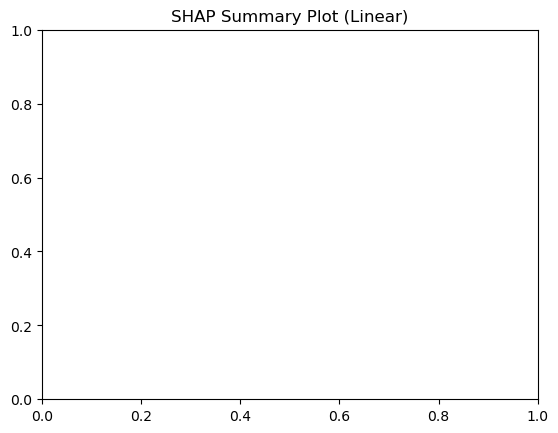

In [161]:
import shap
explainer = shap.Explainer(logreg_final, X_train)

shap_values = explainer(X_train)


shap.summary_plot(shap_values, X_train)
plt.title('SHAP Summary Plot (Linear)')
plt.show()

Acum facem NaiveBayes


=== Cross-Validation on Training Set (Naive Bayes) ===
Accuracy: 0.6083
Precision: 0.5926
Recall: 0.9683
F1-Score: 0.7352
AUC: 0.6901


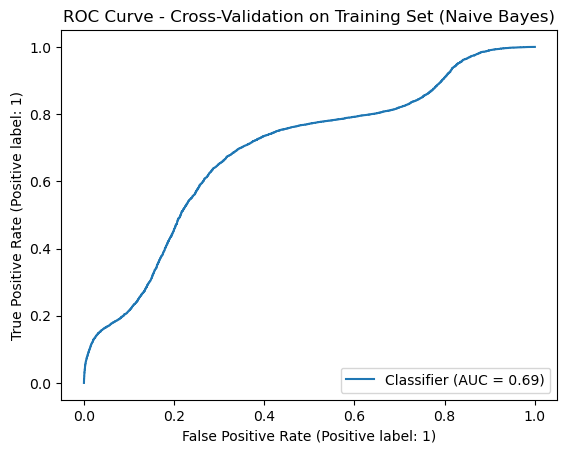

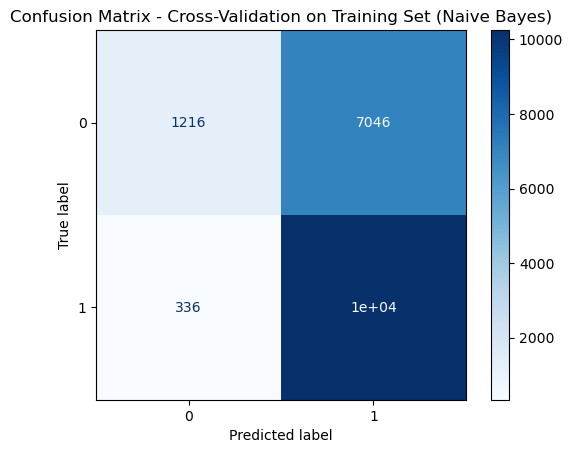


=== Final Evaluation on Test Set (Naive Bayes) ===
Test Accuracy: 0.5660
Test Precision: 0.5661
Test Recall: 0.9996
Test F1-Score: 0.7229
Test AUC: 0.8800


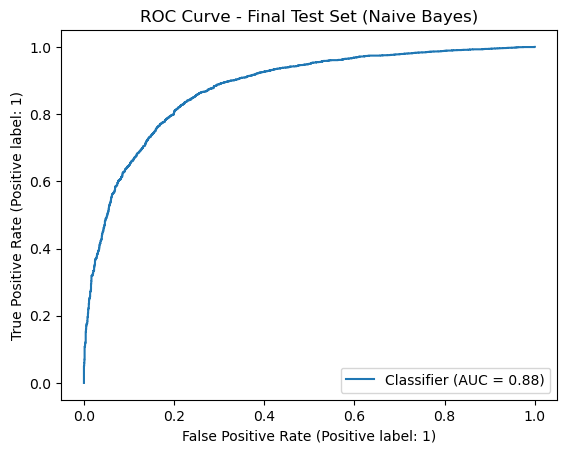

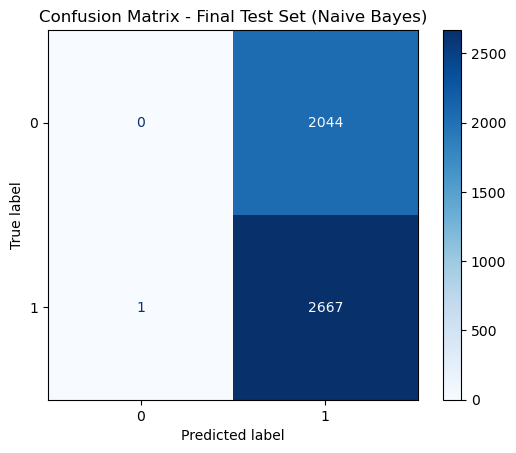

In [162]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

nb = GaussianNB()

y_train_pred_cv = cross_val_predict(nb, X_train, y_train, cv=kfold, method='predict')
y_train_proba_cv = cross_val_predict(nb, X_train, y_train, cv=kfold, method='predict_proba')[:, 1]

print("\n=== Cross-Validation on Training Set (Naive Bayes) ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_cv):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_cv):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_cv):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_cv):.4f}")

RocCurveDisplay.from_predictions(y_train, y_train_proba_cv)
plt.title('ROC Curve - Cross-Validation on Training Set (Naive Bayes)')
plt.show()

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred_cv)).plot(cmap='Blues')
plt.title('Confusion Matrix - Cross-Validation on Training Set (Naive Bayes)')
plt.show()

nb_final = GaussianNB()
nb_final.fit(X_train, y_train)

y_test_pred = nb_final.predict(X_test)
y_test_proba = nb_final.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set (Naive Bayes) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Final Test Set (Naive Bayes)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Final Test Set (Naive Bayes)')
plt.show()


Aici e dezastros, zice ca toti sunt depresivi chiar si cand nu e adevarat.

Acum facem si svc normal


=== Cross-Validation on Training Set (SVM) ===
Accuracy: 0.8420
Precision: 0.8481
Recall: 0.8749
F1-Score: 0.8613
AUC: 0.9150


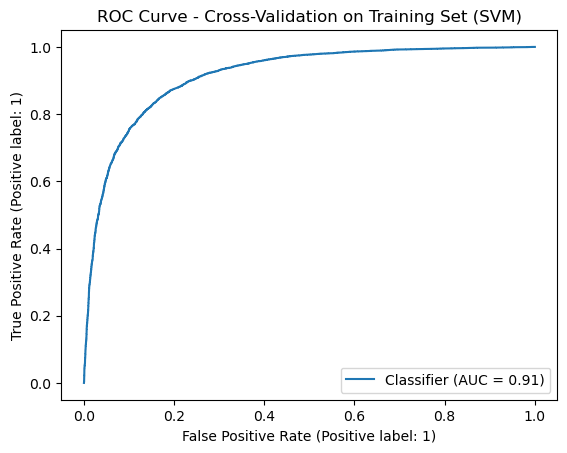

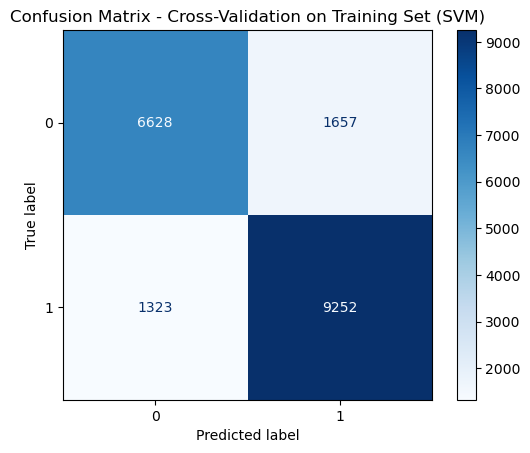


=== Final Evaluation on Test Set (SVM) ===
Test Accuracy: 0.8427
Test Precision: 0.8558
Test Recall: 0.8704
Test F1-Score: 0.8630
Test AUC: 0.9178


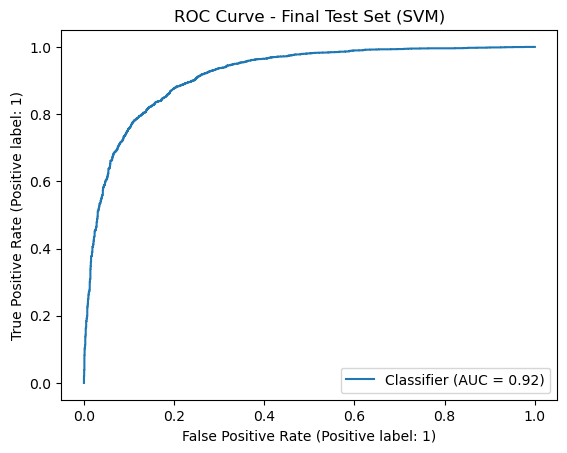

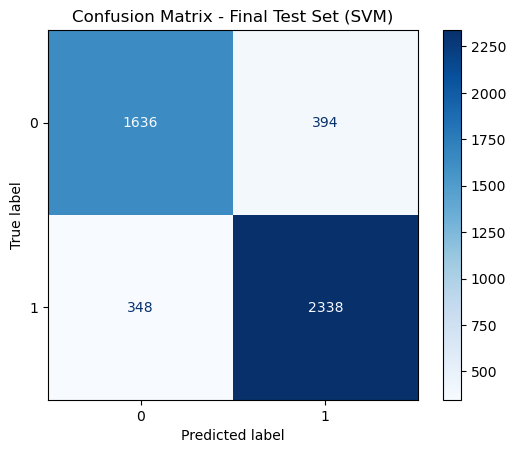

In [43]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

svm = SVC(probability=True, random_state=42)

y_train_pred_cv = cross_val_predict(svm, X_train, y_train, cv=kfold, method='predict')
y_train_proba_cv = cross_val_predict(svm, X_train, y_train, cv=kfold, method='predict_proba')[:, 1]

print("\n=== Cross-Validation on Training Set (SVM) ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_cv):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_cv):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_cv):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_cv):.4f}")

# ROC Curve (Training Set)
RocCurveDisplay.from_predictions(y_train, y_train_proba_cv)
plt.title('ROC Curve - Cross-Validation on Training Set (SVM)')
plt.show()

# Confusion Matrix (Training Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred_cv)).plot(cmap='Blues')
plt.title('Confusion Matrix - Cross-Validation on Training Set (SVM)')
plt.show()

svm_final = SVC(probability=True, random_state=42)
svm_final.fit(X_train, y_train)

y_test_pred = svm_final.predict(X_test)
y_test_proba = svm_final.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set (SVM) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Final Test Set (SVM)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Final Test Set (SVM)')
plt.show()

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)

y_train_pred_cv = cross_val_predict(svm_rbf, X_train, y_train, cv=kfold, method='predict')
y_train_proba_cv = cross_val_predict(svm_rbf, X_train, y_train, cv=kfold, method='predict_proba')[:, 1]

print("\n=== Cross-Validation on Training Set (SVM with RBF Kernel) ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_cv):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_cv):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_cv):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_cv):.4f}")

# ROC Curve (Training Set)
RocCurveDisplay.from_predictions(y_train, y_train_proba_cv)
plt.title('ROC Curve - Cross-Validation on Training Set (SVM with RBF Kernel)')
plt.show()

# Confusion Matrix (Training Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred_cv)).plot(cmap='Blues')
plt.title('Confusion Matrix - Cross-Validation on Training Set (SVM with RBF Kernel)')
plt.show()

svm_rbf_final = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf_final.fit(X_train, y_train)

y_test_pred = svm_rbf_final.predict(X_test)
y_test_proba = svm_rbf_final.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set (SVM with RBF Kernel) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Final Test Set (SVM with RBF Kernel)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Final Test Set (SVM with RBF Kernel)')
plt.show()


KeyboardInterrupt: 

Am început cu un SVC liniar (Support Vector Classifier) pentru a încerca să separ datele. Acesta funcționează bine atunci când datele sunt separabile liniar, adică există o linie dreaptă care poate împărți cele două clase. Totuși, când datele sunt non-liniare (adică amestecate sau nu pot fi separate printr-o linie dreaptă), SVM cu kernel trick devine util. Kernel trick-ul transformă datele într-un spațiu de dimensiuni mai mari, unde ele devin separabile printr-un plan (sau hiperplan). Astfel, am aplicat SVM cu kernel pentru a îmbunătăți performanța și a separa corect datele care nu erau liniare. Aparent erau destul de liniare si imbunatatirea e nesimnificativa.

Nu o sa povestesc din nou despre valorile de la precizie, acuratete, roc si f1 din cauza ca sunt ft asemanatoare cu prima unde am explicat deja fiecare. Pe scurt ii buna precizia, acuratetea si matricea de confuzie ne spune desi avem valori fals pozitive si fals negative modelul are o capacitate destul de buna de clasificare 

Am incercat sa aplic Shap dar nu merge nici cum, doreste prea mult sau resurse

acum facem cu K-Nearest Neighbors 


=== Cross-Validation on Training Set (KNN) ===
Accuracy: 0.8323
Precision: 0.8290
Recall: 0.8830
F1-Score: 0.8552
AUC: 0.9061


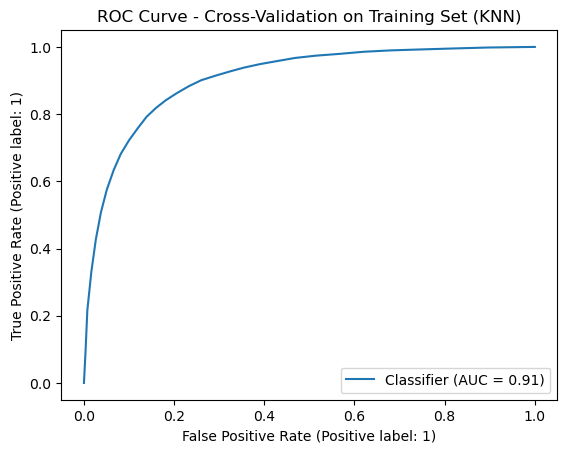

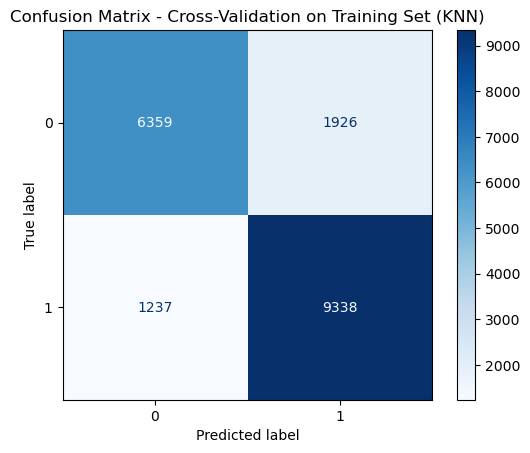


=== Final Evaluation on Test Set (KNN) ===
Test Accuracy: 0.8323
Test Precision: 0.8366
Test Recall: 0.8768
Test F1-Score: 0.8562
Test AUC: 0.9110


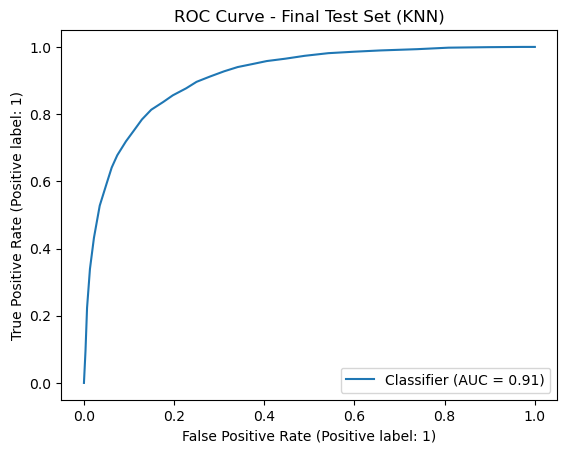

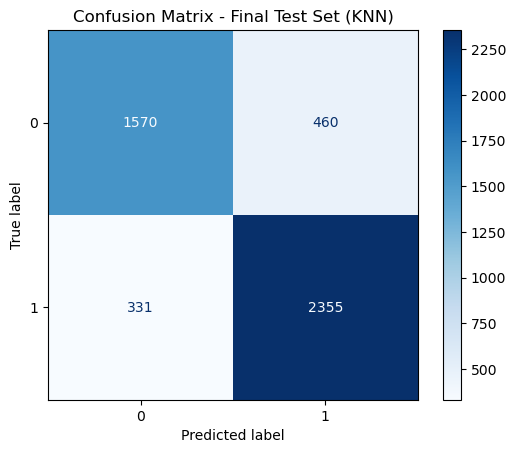

In [54]:
from sklearn.neighbors import KNeighborsClassifier

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

knn = KNeighborsClassifier(n_neighbors=30) 

y_train_pred_cv = cross_val_predict(knn, X_train, y_train, cv=kfold, method='predict')
y_train_proba_cv = cross_val_predict(knn, X_train, y_train, cv=kfold, method='predict_proba')[:, 1]

print("\n=== Cross-Validation on Training Set (KNN) ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_cv):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_cv):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_cv):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_cv):.4f}")

RocCurveDisplay.from_predictions(y_train, y_train_proba_cv)
plt.title('ROC Curve - Cross-Validation on Training Set (KNN)')
plt.show()

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred_cv)).plot(cmap='Blues')
plt.title('Confusion Matrix - Cross-Validation on Training Set (KNN)')
plt.show()

knn_final = KNeighborsClassifier(n_neighbors=30)
knn_final.fit(X_train, y_train)

y_test_pred = knn_final.predict(X_test)
y_test_proba = knn_final.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set (KNN) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Final Test Set (KNN)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Final Test Set (KNN)')
plt.show()

 ROC curve este cam „colțuros” și nu are o formă lină, acest lucru este un semn că modelul meu face alegeri foarte "hotărâte" (adică cu praguri de decizie extreme). De obicei, o curbă ROC mai lină și mai fluidă sugerează un model care face decizii mai graduale și mai echilibrate în privința alegerii între clase.

In [68]:
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Creăm explicatorul LIME
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,  
    feature_names=X_train.columns,
    class_names=['Class 0', 'Class 1'], 
    mode='classification' 
)

instance = X_test.iloc[0] 

lime_explanation = lime_explainer.explain_instance(
    instance.values, 
    knn_final.predict_proba, 
    num_features=5  
)

lime_explanation.show_in_notebook()


C:\Users\Asus\miniconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Decision Tree


=== Cross-Validation on Training Set (Decision Tree) ===
Accuracy: 0.7651
Precision: 0.7895
Recall: 0.7932
F1-Score: 0.7913
AUC: 0.7611


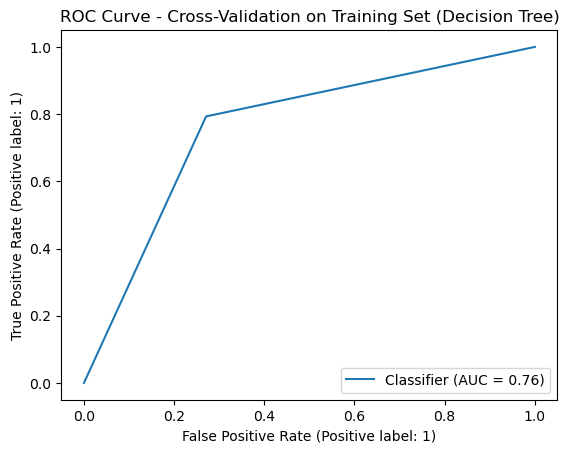

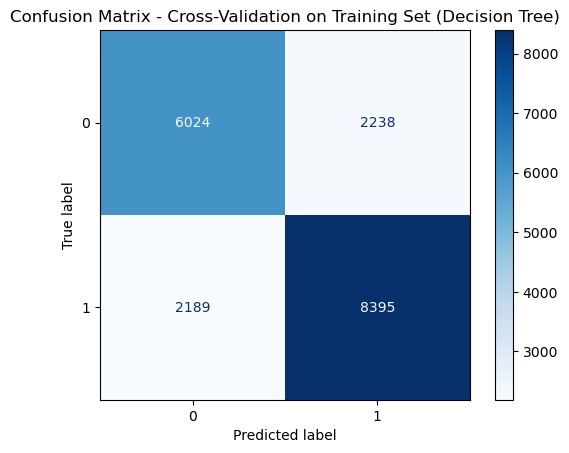


=== Final Evaluation on Test Set (Decision Tree) ===
Test Accuracy: 0.7742
Test Precision: 0.8078
Test Recall: 0.7890
Test F1-Score: 0.7983
Test AUC: 0.7719


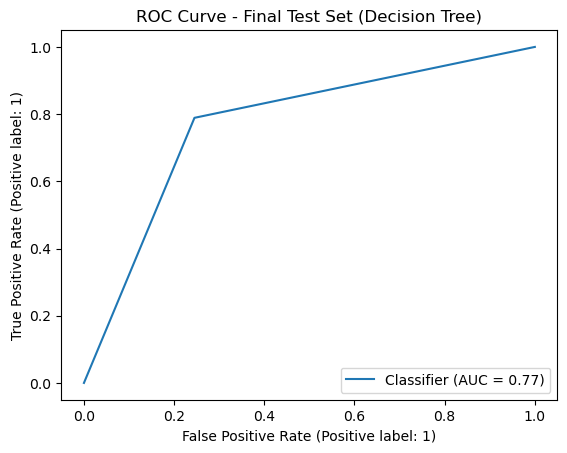

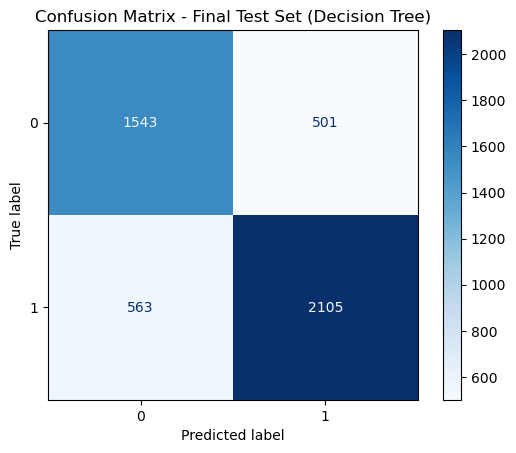

In [223]:
from sklearn.tree import DecisionTreeClassifier

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

decision_tree = DecisionTreeClassifier(random_state=42)

y_train_pred_cv = cross_val_predict(decision_tree, X_train, y_train, cv=kfold, method='predict')
y_train_proba_cv = cross_val_predict(decision_tree, X_train, y_train, cv=kfold, method='predict_proba')[:, 1]

print("\n=== Cross-Validation on Training Set (Decision Tree) ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_cv):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_cv):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_cv):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_cv):.4f}")

# ROC Curve (Training Set)
RocCurveDisplay.from_predictions(y_train, y_train_proba_cv)
plt.title('ROC Curve - Cross-Validation on Training Set (Decision Tree)')
plt.show()

# Confusion Matrix (Training Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred_cv)).plot(cmap='Blues')
plt.title('Confusion Matrix - Cross-Validation on Training Set (Decision Tree)')
plt.show()

decision_tree_final = DecisionTreeClassifier(random_state=42)
decision_tree_final.fit(X_train, y_train)

y_test_pred = decision_tree_final.predict(X_test)
y_test_proba = decision_tree_final.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set (Decision Tree) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Final Test Set (Decision Tree)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Final Test Set (Decision Tree)')
plt.show()

e cu un colt si liniar dar nu rotund frumos spre 1 asa ca o sa optimizam algoritmul schimband diversi parametrii

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

param_grid = {
    'max_depth': [5, 7,8,10,],
    'min_samples_split': [5, 10, 15], 
    'min_samples_leaf': [1, 2, 4, 5, 6, 8],
    'max_features': ['sqrt', 'log2', 5, 10, 15, 20, 25, 30, 40],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

best_dt = grid_search.best_estimator_

y_test_pred = best_dt.predict(X_test)
y_test_proba = best_dt.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set (GridSearchCV optimized Decision Tree) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")


Best hyperparameters found by GridSearchCV:
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 30, 'min_samples_leaf': 4, 'min_samples_split': 10}

=== Final Evaluation on Test Set (GridSearchCV optimized Decision Tree) ===
Test Accuracy: 0.8242
Test Precision: 0.8310
Test Recall: 0.8678
Test F1-Score: 0.8490
Test AUC: 0.8965



=== Training Set Evaluation (Optimized Decision Tree) ===
Training Accuracy: 0.8403
Training Precision: 0.8398
Training Recall: 0.8839
Training F1-Score: 0.8613
Training AUC: 0.9151


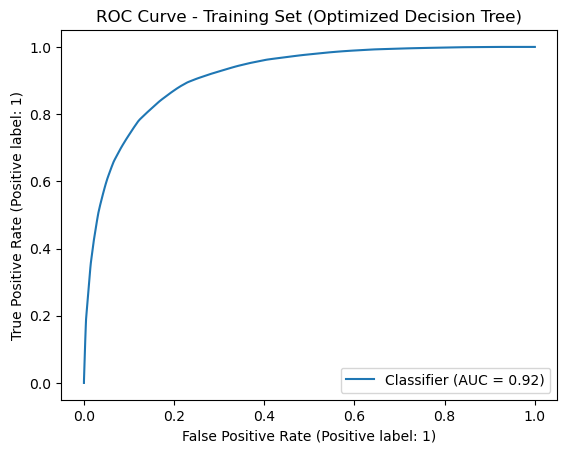

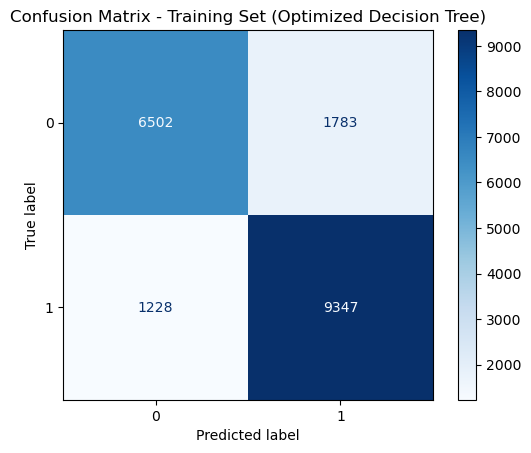


=== Test Set Evaluation (Optimized Decision Tree) ===
Test Accuracy: 0.8242
Test Precision: 0.8310
Test Recall: 0.8678
Test F1-Score: 0.8490
Test AUC: 0.8965


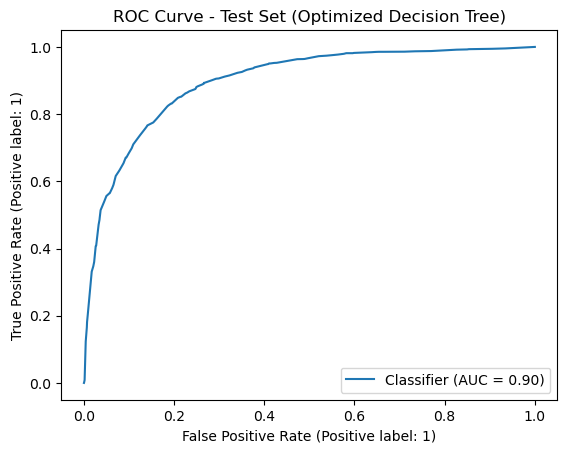

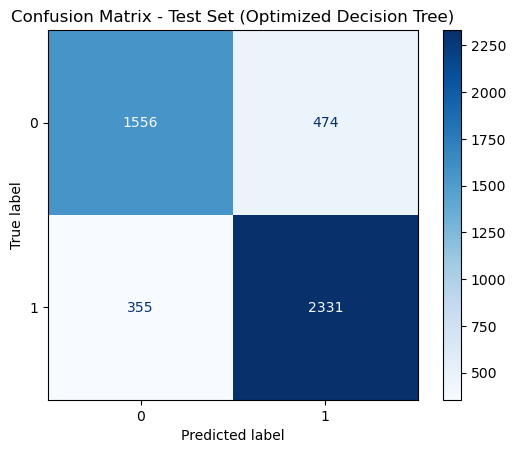

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n=== Training Set Evaluation (Optimized Decision Tree) ===")

y_train_pred = best_dt.predict(X_train)
y_train_proba = best_dt.predict_proba(X_train)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Training AUC: {train_auc:.4f}")

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title('ROC Curve - Training Set (Optimized Decision Tree)')
plt.show()

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Training Set (Optimized Decision Tree)')
plt.show()

print("\n=== Test Set Evaluation (Optimized Decision Tree) ===")

y_test_pred = best_dt.predict(X_test)
y_test_proba = best_dt.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Test Set (Optimized Decision Tree)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set (Optimized Decision Tree)')
plt.show()


Dacă arborele de decizie are o regulă foarte strictă, adică un prag foarte mare pentru a decide dacă o instanță este pozitivă sau negativă, atunci curba ROC poate deveni colțuroasă. Aceste tranziții bruște între corect/greșit se datorează faptului că modelul face predicții foarte clare, dar nu variază mult pentru instanțele care sunt aproape de limita de decizie.


=== Cross-Validation on Training Set (Random Forest) ===
Accuracy: 0.8381
Precision: 0.8497
Recall: 0.8647
F1-Score: 0.8571
AUC: 0.9127


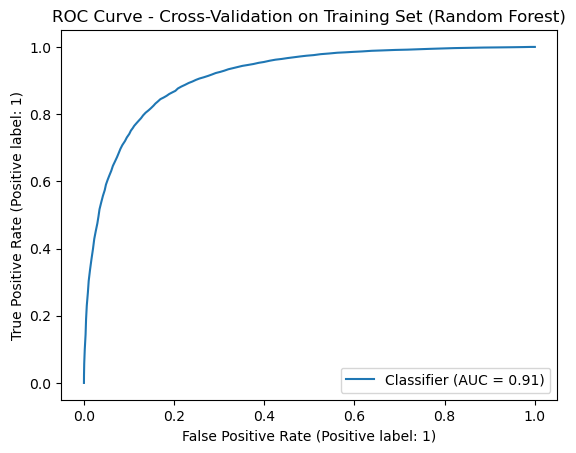

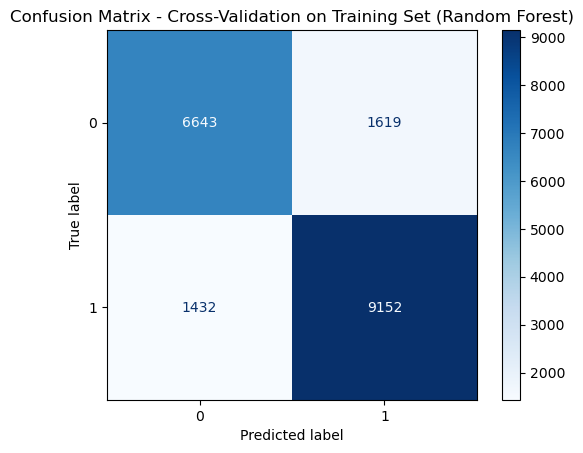


=== Final Evaluation on Test Set (Random Forest) ===
Test Accuracy: 0.8406
Test Precision: 0.8536
Test Recall: 0.8673
Test F1-Score: 0.8604
Test AUC: 0.9160


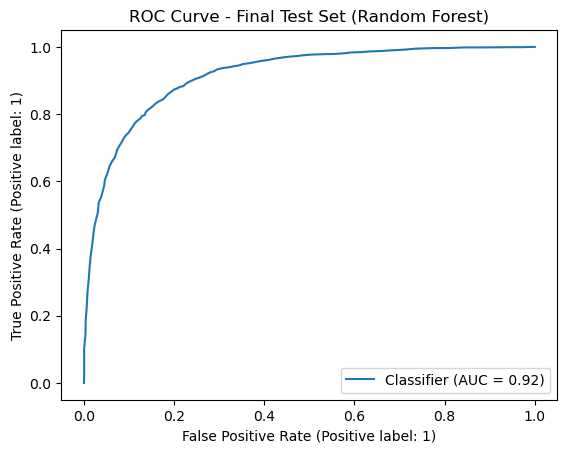

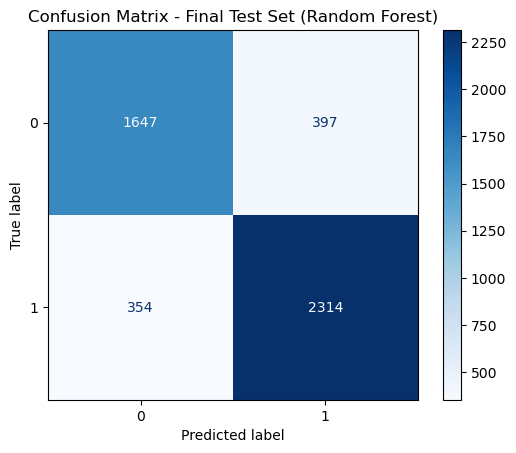

In [258]:

from sklearn.ensemble import RandomForestClassifier

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)

y_train_pred_cv = cross_val_predict(rf, X_train, y_train, cv=kfold, method='predict')
y_train_proba_cv = cross_val_predict(rf, X_train, y_train, cv=kfold, method='predict_proba')[:, 1]

print("\n=== Cross-Validation on Training Set (Random Forest) ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_cv):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_cv):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_cv):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_cv):.4f}")

# ROC Curve (Training Set)
RocCurveDisplay.from_predictions(y_train, y_train_proba_cv)
plt.title('ROC Curve - Cross-Validation on Training Set (Random Forest)')
plt.show()

# Confusion Matrix (Training Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred_cv)).plot(cmap='Blues')
plt.title('Confusion Matrix - Cross-Validation on Training Set (Random Forest)')
plt.show()

rf_final = RandomForestClassifier(random_state=42)
rf_final.fit(X_train, y_train)

y_test_pred = rf_final.predict(X_test)
y_test_proba = rf_final.predict_proba(X_test)[:, 1]


print("\n=== Final Evaluation on Test Set (Random Forest) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Final Test Set (Random Forest)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Final Test Set (Random Forest)')
plt.show()

e putin mai bun asa ca hai sa-l optimizam si pe acesta folosind GridSearchCC care face toate combinatiile de parametrii in cautarea celui mai bun model

Best hyperparameters found by GridSearchCV:
{'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 40}

=== Final Evaluation on Test Set (GridSearchCV optimized Random Forest) ===
Test Accuracy: 0.8430
Test Precision: 0.8531
Test Recall: 0.8729
Test F1-Score: 0.8629
Test AUC: 0.9170


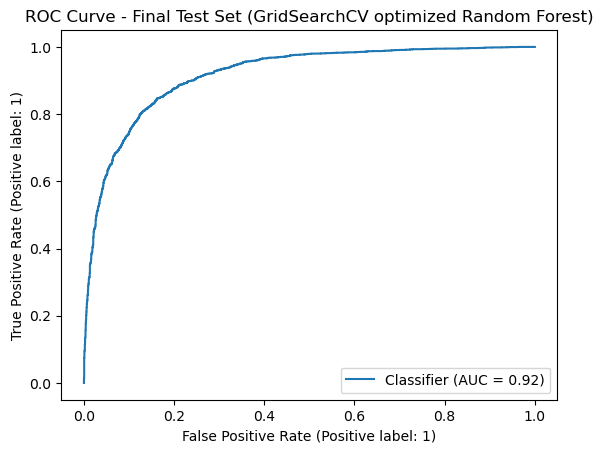

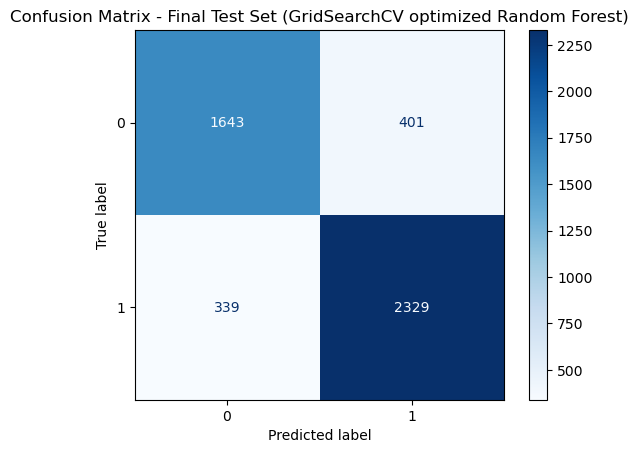

In [260]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [30, 40, 50], 
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2', 20, 15, 30, None]  
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set (GridSearchCV optimized Random Forest) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Final Test Set (GridSearchCV optimized Random Forest)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Final Test Set (GridSearchCV optimized Random Forest)')
plt.show()


Nu este mare diferenta, sa vedem si pe train cum arata datele si daca avem overfiting


=== Training Set Evaluation (Optimized Forest) ===
Training Accuracy: 0.8785
Training Precision: 0.8778
Training Recall: 0.9105
Training F1-Score: 0.8938
Training AUC: 0.9530


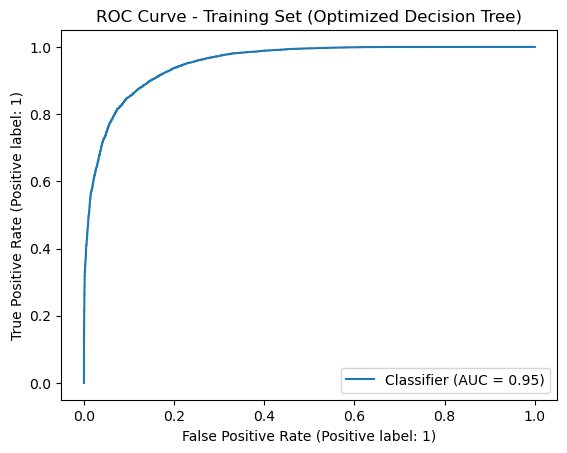

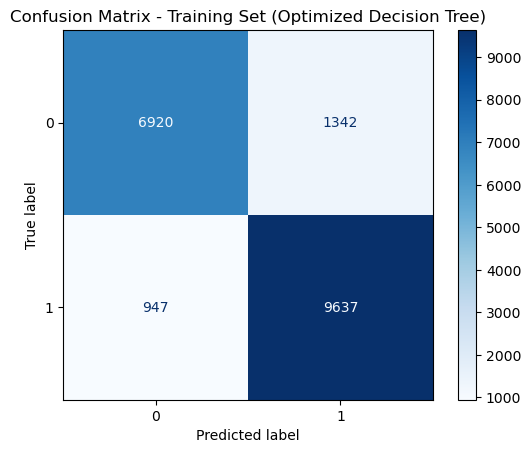


=== Test Set Evaluation (Optimized Decision Tree) ===
Test Accuracy: 0.8430
Test Precision: 0.8531
Test Recall: 0.8729
Test F1-Score: 0.8629
Test AUC: 0.9170


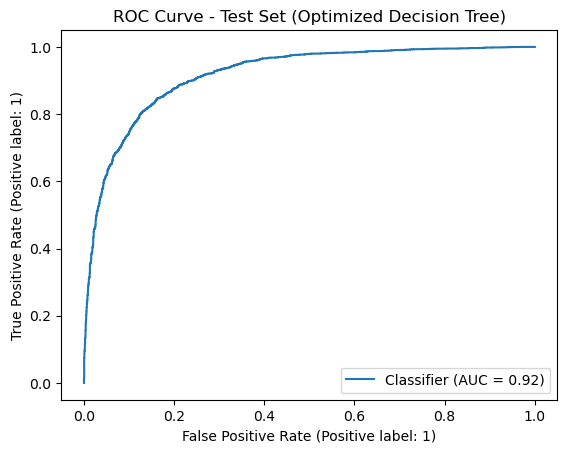

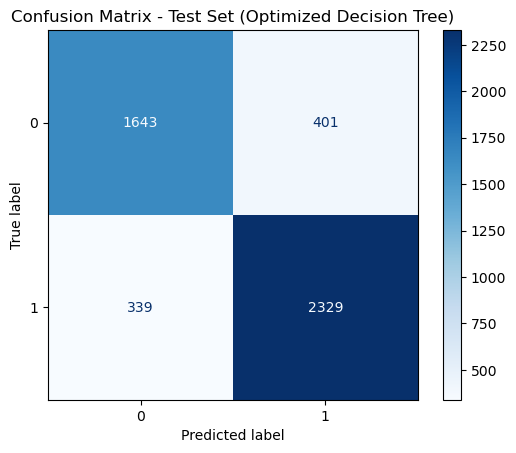

In [262]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


print("\n=== Training Set Evaluation (Optimized Forest) ===")


y_train_pred = best_rf.predict(X_train)
y_train_proba = best_rf.predict_proba(X_train)[:, 1]


train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)


print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Training AUC: {train_auc:.4f}")

# Plot ROC Curve (Training Set)
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title('ROC Curve - Training Set (Optimized Decision Tree)')
plt.show()

# Confusion Matrix (Training Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Training Set (Optimized Decision Tree)')
plt.show()

print("\n=== Test Set Evaluation (Optimized Decision Tree) ===")


y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]


test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)


print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Test Set (Optimized Decision Tree)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set (Optimized Decision Tree)')
plt.show()


Se descurca mai bine pe training decat pe testing dar nu e asa de mare diferenta incat sa zicem ca avem overfiting

Acum sa facem Xtreme Gradient Boost

Best hyperparameters found by GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.8}

=== Training Set Evaluation (XGBoost) ===
Training Accuracy: 0.8576
Training Precision: 0.8629
Training Recall: 0.8876
Training F1-Score: 0.8750
Training AUC: 0.9322


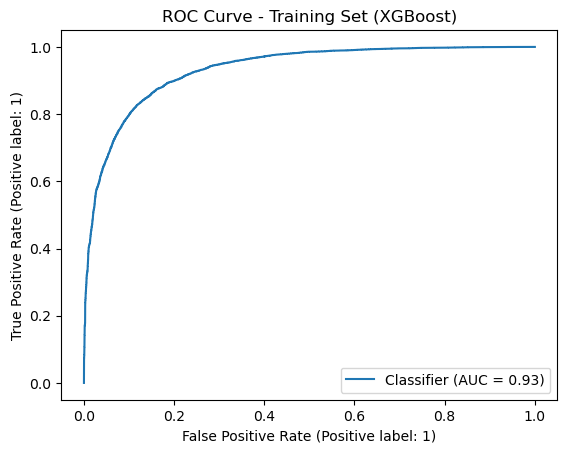

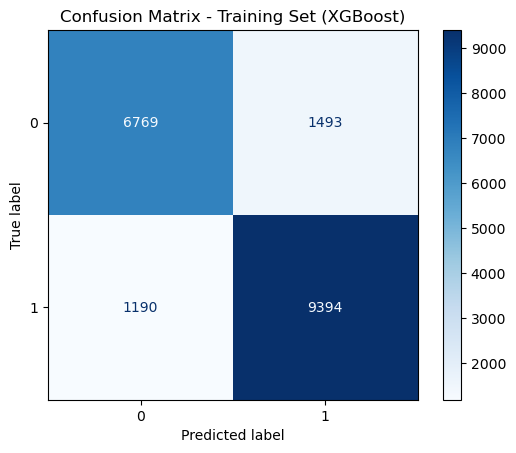


=== Test Set Evaluation (XGBoost) ===
Test Accuracy: 0.8480
Test Precision: 0.8578
Test Recall: 0.8771
Test F1-Score: 0.8673
Test AUC: 0.9218


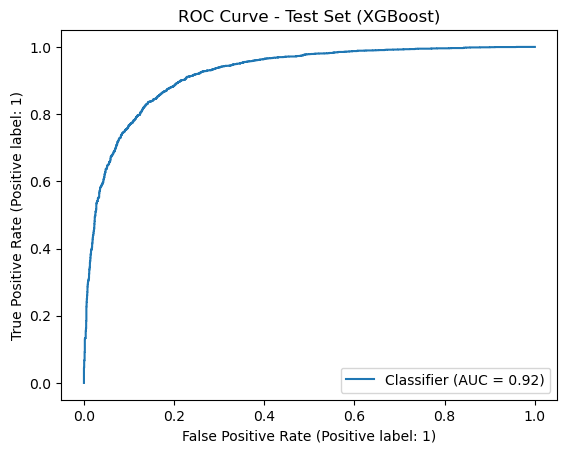

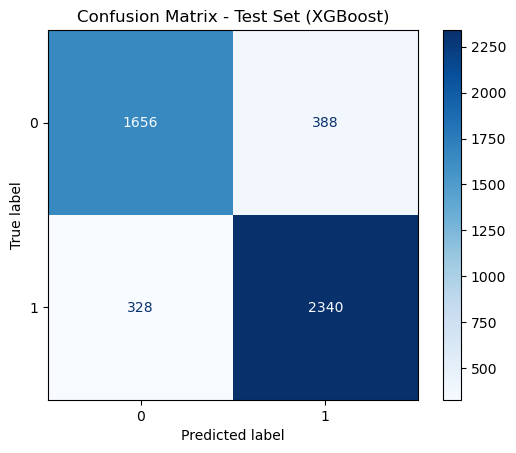

In [269]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False)

param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [3, 5, 7, 10], 
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.85, 0.9, 1.0], 
    'gamma': [0, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

print("Best hyperparameters found by GridSearchCV:")
print(grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

print("\n=== Training Set Evaluation (XGBoost) ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Training AUC: {train_auc:.4f}")

# Plot ROC Curve (Training Set)
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title('ROC Curve - Training Set (XGBoost)')
plt.show()

# Confusion Matrix (Training Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Training Set (XGBoost)')
plt.show()

y_test_pred = best_xgb.predict(X_test)
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print("\n=== Test Set Evaluation (XGBoost) ===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Test Set (XGBoost)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set (XGBoost)')
plt.show()


Cam acelasi lucru in final, metriciile sunt asemanatoare, linia e tot bumpy dar nu e asa de colturoasa

100%|===================| 18816/18846 [01:04<00:00]        

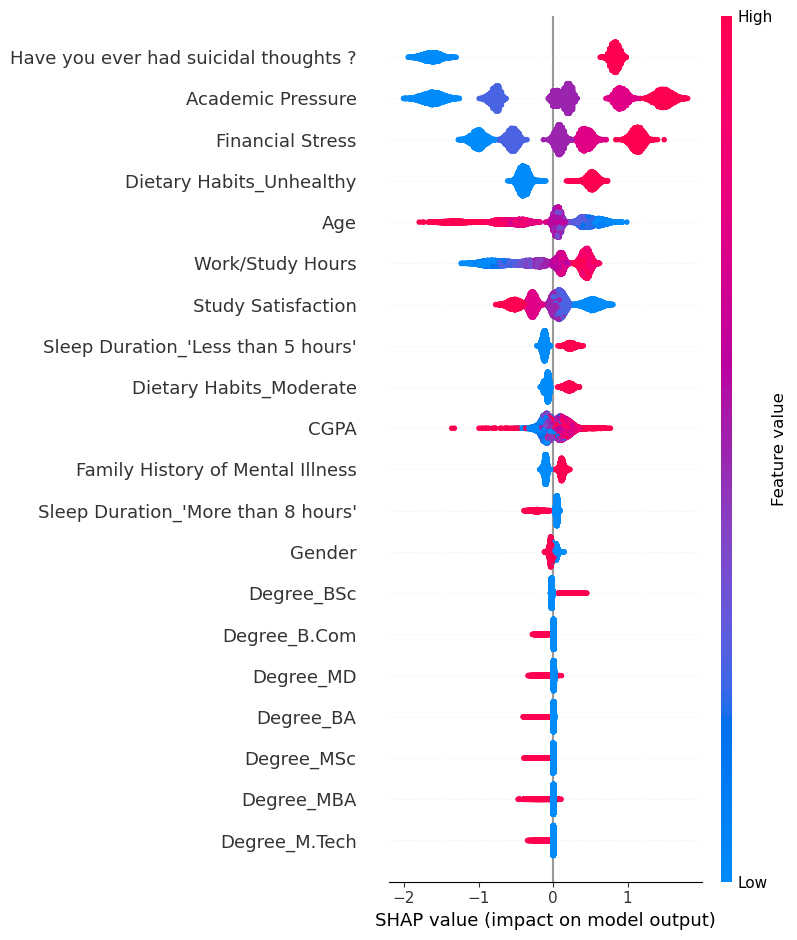

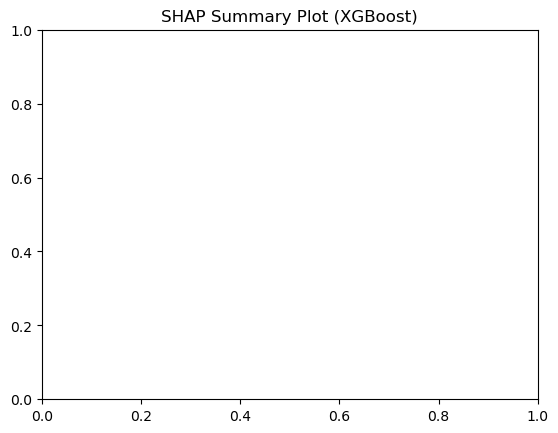

In [280]:
import shap
explainer = shap.Explainer(best_xgb, X_train)

# Get SHAP values for the training set
shap_values = explainer(X_train)

# Plot SHAP summary plot (Global explanation)
shap.summary_plot(shap_values, X_train)
plt.title('SHAP Summary Plot (XGBoost)')
plt.show()

Observam ca gandurile de sinucidere, stresul academic, problemele financiare, varsta si orele de studiu sunt principalii factori care influentiaza alegerea modelului.

Acum facem un CatBoostClasifier si il optimizam si pe acesta

Best hyperparameters found by GridSearchCV:
{'border_count': 128, 'depth': 6, 'iterations': 50, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

=== Training Set Evaluation (CatBoost) ===
Training Accuracy: 0.8516
Training Precision: 0.8556
Training Recall: 0.8851
Training F1-Score: 0.8701
Training AUC: 0.9274


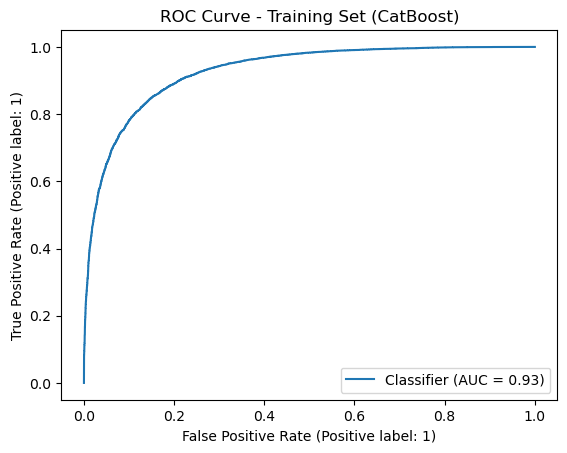

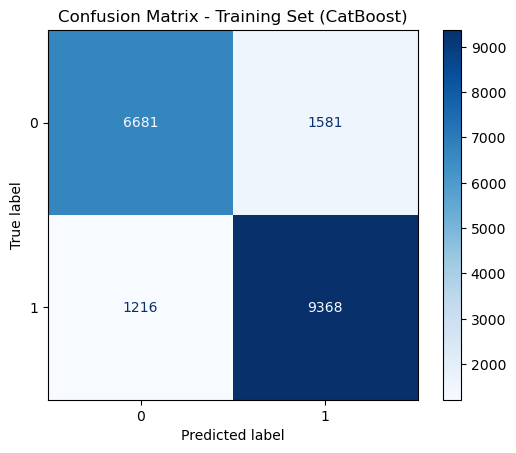


=== Test Set Evaluation (CatBoost) ===
Test Accuracy: 0.8504
Test Precision: 0.8573
Test Recall: 0.8827
Test F1-Score: 0.8698
Test AUC: 0.9227


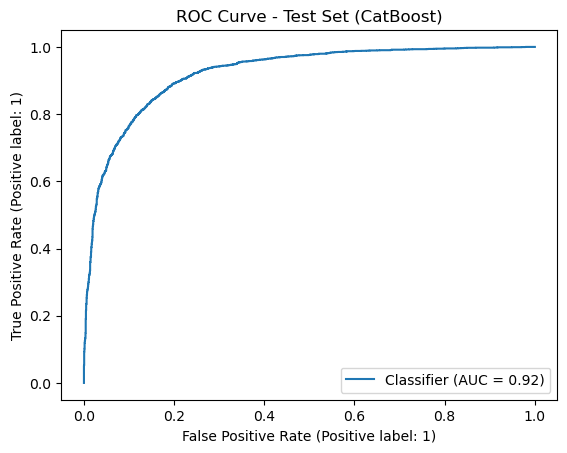

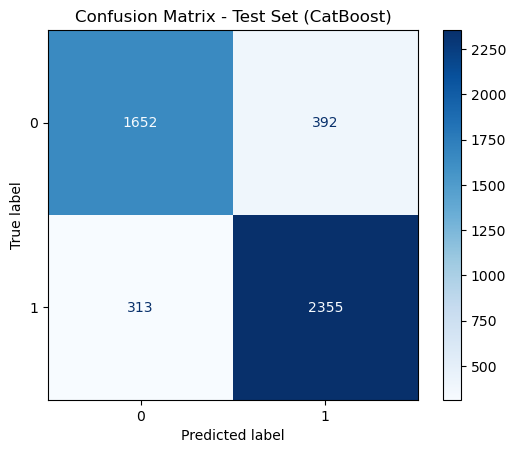

In [272]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

catboost_model = CatBoostClassifier(random_state=42, cat_features=[], verbose=0)

param_grid = {
    'iterations': [30, 50, 60], 
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5], 
    'border_count': [32, 64, 128]
}

grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_catboost.fit(X_train, y_train)

print("Best hyperparameters found by GridSearchCV:")
print(grid_search_catboost.best_params_)

best_catboost = grid_search_catboost.best_estimator_


y_train_pred = best_catboost.predict(X_train)
y_train_proba = best_catboost.predict_proba(X_train)[:, 1]


train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

print("\n=== Training Set Evaluation (CatBoost) ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Training AUC: {train_auc:.4f}")

# Plot ROC Curve (Training Set)
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title('ROC Curve - Training Set (CatBoost)')
plt.show()

# Confusion Matrix (Training Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Training Set (CatBoost)')
plt.show()

y_test_pred = best_catboost.predict(X_test)
y_test_proba = best_catboost.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# Print test set metrics
print("\n=== Test Set Evaluation (CatBoost) ===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Test Set (CatBoost)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set (CatBoost)')
plt.show()


E putin mai bun dar nu e o diferenta incredibila

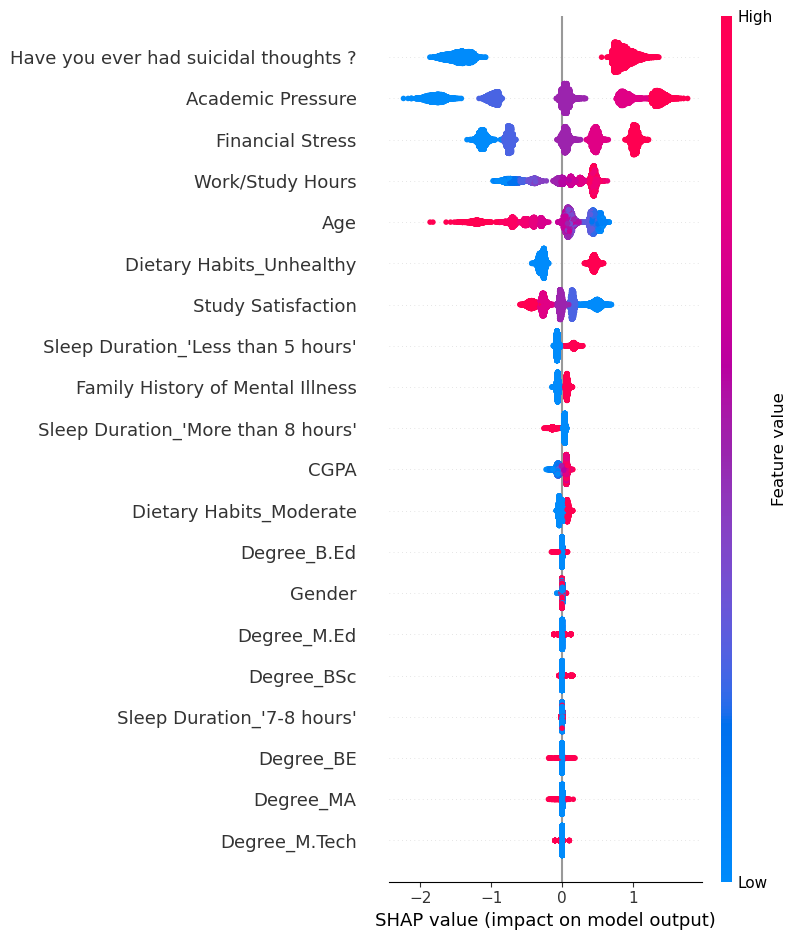

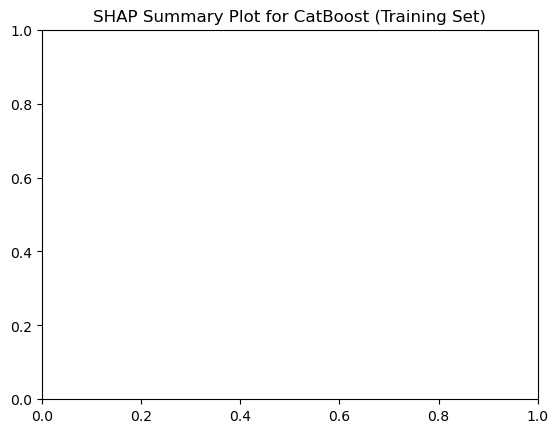

In [279]:
import shap

explainer = shap.Explainer(best_catboost)

# 3. Get SHAP values for the training set
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)
plt.title('SHAP Summary Plot for CatBoost (Training Set)')
plt.show()

Si loa acesta observam ca gandurile de sinucidere, stresul academic, problemele financiare, varsta si orele de studiu sunt principalii factori care influentiaza alegerea modelului.


Acum facem Explainable Boosting Machine


=== Cross-Validation on Training Set (EBM) ===
Training Accuracy: 0.8450
Training Precision: 0.8505
Training Recall: 0.8783
Training F1-Score: 0.8642
Training AUC: 0.9205


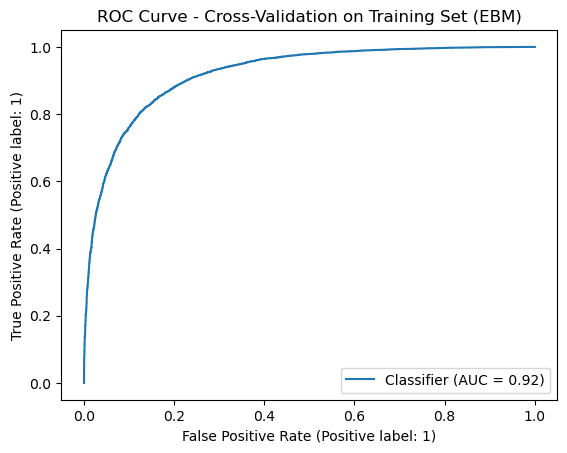

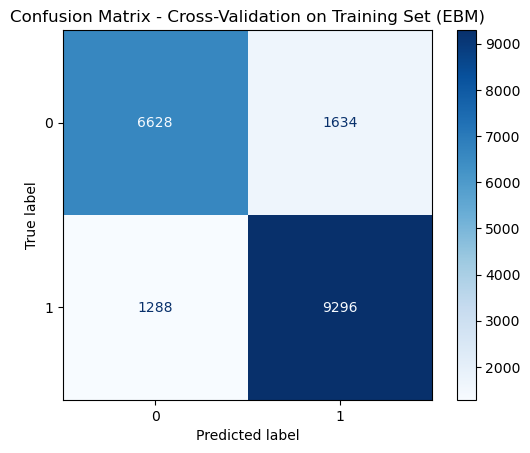


=== Final Evaluation on Test Set (EBM) ===
Test Accuracy: 0.8478
Test Precision: 0.8567
Test Recall: 0.8782
Test F1-Score: 0.8673
Test AUC: 0.9229


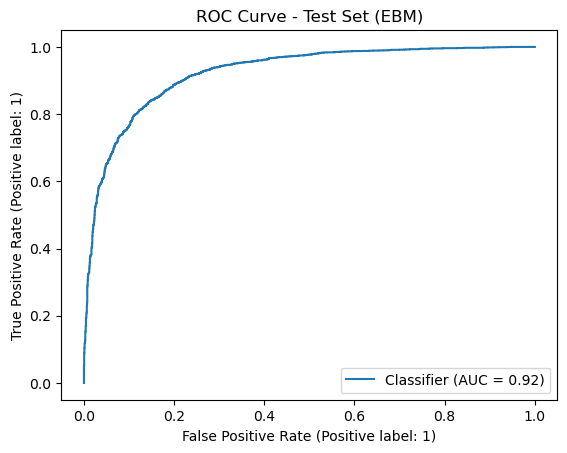

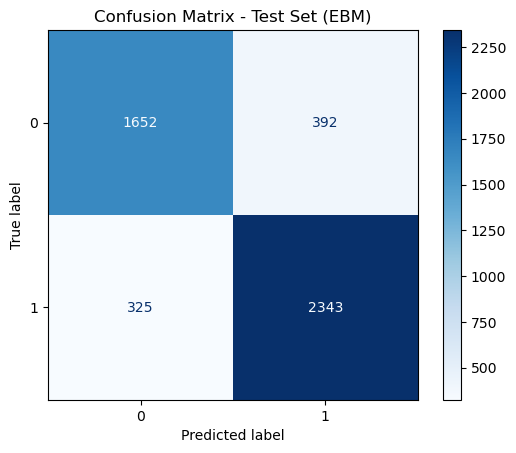

In [49]:
from interpret.glassbox import ExplainableBoostingClassifier


ebm = ExplainableBoostingClassifier(random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

y_train_pred_cv = cross_val_predict(ebm, X_train, y_train, cv=kfold, method='predict')
y_train_proba_cv = cross_val_predict(ebm, X_train, y_train, cv=kfold, method='predict_proba')[:, 1]

print("\n=== Cross-Validation on Training Set (EBM) ===")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_cv):.4f}")
print(f"Training Precision: {precision_score(y_train, y_train_pred_cv):.4f}")
print(f"Training Recall: {recall_score(y_train, y_train_pred_cv):.4f}")
print(f"Training F1-Score: {f1_score(y_train, y_train_pred_cv):.4f}")
print(f"Training AUC: {roc_auc_score(y_train, y_train_proba_cv):.4f}")

RocCurveDisplay.from_predictions(y_train, y_train_proba_cv)
plt.title('ROC Curve - Cross-Validation on Training Set (EBM)')
plt.show()

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_train_pred_cv)).plot(cmap='Blues')
plt.title('Confusion Matrix - Cross-Validation on Training Set (EBM)')
plt.show()

ebm.fit(X_train, y_train)

y_test_pred = ebm.predict(X_test)
y_test_proba = ebm.predict_proba(X_test)[:, 1]

print("\n=== Final Evaluation on Test Set (EBM) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# Plot ROC Curve (Test Set)
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve - Test Set (EBM)')
plt.show()

# Confusion Matrix (Test Set)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set (EBM)')
plt.show()

aproape la fel ca la catBoost

In [69]:
from interpret import show

explainer = ebm.explain_global()

# Show the feature importance
show(explainer)

<!-- http://127.0.0.1:7001/2532275904608/ -->

De data asta vedem ca si dieta nesanatoasa afecteaza destul de mult starea studentului

Toate modelele inafara de Naive Bayes au rezultate asemanatoare si sunt relativ ok ca performanta si nici una nu face overfiting
